In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, desc, asc, sum as _sum, md5, col

# Builder
spark = SparkSession.builder \
    .appName("SMS Analysis") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()


In [2]:
# Path del dataset
eventos_path = "../data/events.csv.gz"
free_sms_path = "../data/free_sms_destinations.csv.gz"

# CSV de eventos
eventos_df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(eventos_path)

# CSV de destinos gratuitos
free_sms_df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(free_sms_path)

In [3]:
# TempViews to Query
eventos_df.createOrReplaceTempView('eventos_df')
free_sms_df.createOrReplaceTempView('free_sms_df')


In [4]:
# Esta es la versión con PySpark

In [5]:
# Registros válidos y con SMS
eventos_sms = eventos_df.filter(
    (col("id_source").isNotNull()) &
    (col("id_destination").isNotNull()) &
    (col("sms") > 0)
)

# Join de registros con id para SMS gratuitos
eventos_sms_gratis = eventos_sms.join(
    free_sms_df.withColumnRenamed("id", "free_sms_id"), # Renombre para evitar confusión
    eventos_sms["id_destination"] == col("free_sms_id"),
    how="left"
)

# Precios -- step 1/2
eventos_tarifados = eventos_sms_gratis.withColumn(
    "price",
    when(col("free_sms_id").isNotNull(), 0.0) # No contabiliza los sms free
    .when(col("region").cast("int").between(1, 5), 1.5)
    .when(col("region").cast("int").between(6, 9), 2.0)
    .otherwise(0.0)
)

# Facturación total -- step 2/2
eventos_tarifados = eventos_tarifados.filter(col("free_sms_id").isNull()).withColumn(
    "sms_income", col("sms") * col("price")
)

# Agrupación de sms_income
total_facturado = eventos_tarifados.groupBy("region").agg(
    _sum("sms").alias("total_sms_enviados"),
    _sum("sms_income").alias("total_sms_income")
)

total_facturado.sort(asc("region")).show()

total_sms_income = total_facturado.agg(
    _sum("total_sms_income").alias("total")
).collect()[0]["total"]

print(f"Total facturado: ${total_sms_income}")


+------+------------------+----------------+
|region|total_sms_enviados|total_sms_income|
+------+------------------+----------------+
|     1|             13073|         19609.5|
|     2|              9829|         14743.5|
|     3|             16849|         25273.5|
|     4|             26226|         39339.0|
|     5|             32981|         49471.5|
|     6|             25389|         50778.0|
|     7|             39299|         78598.0|
|     8|             15216|         30432.0|
|     9|             41561|         83122.0|
+------+------------------+----------------+

Total facturado: $391367.0


### Ejercicio 2

##### Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de SMS y el monto total a facturar a cada uno.
##### Además del ID, incluir el ID hasheado mediante el algoritmo MD5.
##### Escribir el dataset en formato parquet con compresión gzip.

In [6]:
facturacion_ids = eventos_tarifados.groupBy("id_source").agg(
    _sum("sms").alias("total_sms_enviados"),
    _sum("sms_income").alias("total_sms_income")
)

top_100_ids_billing = facturacion_ids.sort(desc("total_sms_income")).limit(100)

top_100_ids_hashed = top_100_ids_billing.withColumn("id_source_md5", md5(col("id_source")))

top_100_ids_hashed.show(truncate = False)

top_100_ids_hashed\
    .write\
    .mode("overwrite")\
    .option("compression", "gzip")\
    .parquet("/home/jovyan/output/top_100_ids.parquet")

+---------+------------------+----------------+--------------------------------+
|id_source|total_sms_enviados|total_sms_income|id_source_md5                   |
+---------+------------------+----------------+--------------------------------+
|4D3      |12940             |23403.0         |911914c7729eedbdf5b0f03159f451a9|
|76D      |7347              |13664.0         |bd180b7811395cbce5076b52a78ca50d|
|07E      |2357              |4226.0          |14a0660ae2f5d186882df86c2972fa93|
|541      |1380              |2526.0          |16c222aa19898e5058938167c8ab6c57|
|C25      |1344              |2019.0          |0bfa0b57d99985aa138ce05055a3c5db|
|17D      |633               |1209.0          |7521526054bb89ba243073f7e5e541ec|
|3AE      |589               |1087.5          |6a57072949dbc409cc48ef7bd8b05335|
|B86      |649               |1054.5          |bc97b32ee2abb9c18aad55b9da9f51c0|
|E89      |607               |979.5           |5135cc35322269f2fb397b4f81426938|
|B71      |488              

In [7]:
## Ejercicio 3

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# Agrupamos por hora y sumamos llamadas
calls_hora = eventos_df.groupBy("hour").agg(
    _sum("calls").alias("total_calls")
).orderBy("hour")

In [10]:
# TempView to Pandas
calls_pd = calls_hora.toPandas()

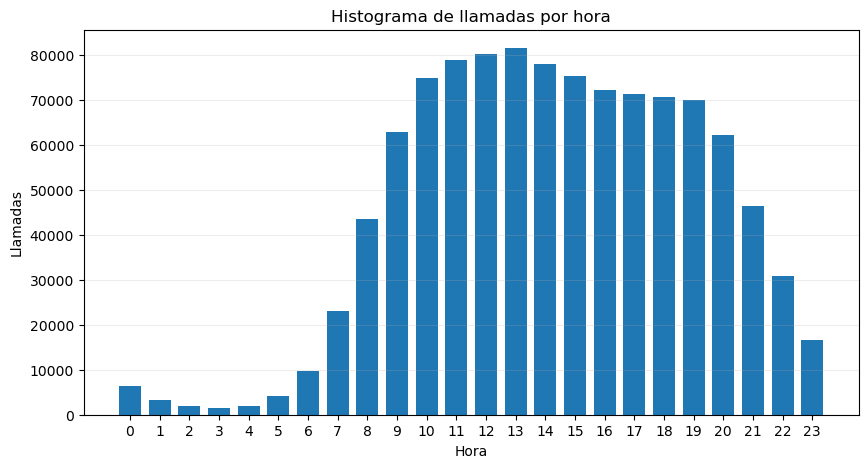

In [11]:
# Plot settings
plt.figure(figsize=(10, 5))
plt.bar(calls_pd["hour"], calls_pd["total_calls"], width=0.75) # Ejes y barras
plt.xlabel("Hora")
plt.ylabel("Llamadas")
plt.title("Histograma de llamadas por hora")
plt.xticks(range(0, 24)) # Horas del día
plt.grid(axis='y', linestyle='-', alpha=0.225)
# PNG
plt.savefig("histograma_llamadas.png")
plt.show()